In [1]:
import os
from functools import reduce
from typing import List
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from Model.ModelEarly2D import ModelEarly2D, ModeTestChannel
physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
config = tf.config.experimental.set_memory_growth(physical_devices[0], True)

read config params

In [2]:
f = open("config.txt")
configParams = f.readlines()
f.close()
configParams = eval("\n".join(configParams))

multiplierCoord = configParams["multiplierCoord"]
thresholdCuDi = configParams["thresholdCuDi"]# value in pixel
dimensionsImage,canal = np.array(configParams["dimensionsOutputImage"]),2 # x and
actionFileName = "Actions.csv"

In [3]:
nbClass=31
pathModelGeneral,separator = "C:\\workspace2\\Datasets\\2D\\MTG\\MTGSetB\\Log\\splendid-bush-10930\\","\\"
pathModel = pathModelGeneral+"Weights\\model"
pathPreprocessedData = "C:\\workspace2\\Datasets\\2D\\MTG\\MTGSetB\\PreprocessedData\\"

dilatationRates = [1, 2, 4, 8, 16, 1, 2, 4, 8, 16]
config = {    "multiplierCoord":multiplierCoord,
              "treshCudi":thresholdCuDi,
                "dimension":[dimensionsImage[0],dimensionsImage[1]],
               "batchSize": 40,
               "lambdahyper": 32,
                "couverture":0.75,
              "weightLoss1":0.5,
              "learning_rate":0.003,
               "doGlu":False,
               "dropoutVal":0.1,
               "denseSize":150,
               "denseDropout":0.3,
               "nbFeatureMap":25,
               "dilatationRates":dilatationRates,
               "maxPoolSpatial":True,
               "poolSize":(1,3,3),
                "nbDenseLayer":1,
              "modeChannel":ModeTestChannel.BOTH
               }

### Prepare the test data

In [4]:
trainPart=0.85
trainFiles = os.listdir(pathPreprocessedData+"Train")
nbTrain = int(trainPart*len(trainFiles))
nbValid = len(trainFiles)-nbTrain
train = trainFiles[0:nbTrain]
validFiles = trainFiles[nbTrain:]
testFiles = validFiles


def generatorData(pathPrepro:str, filesList: List[str]):
    for file in filesList:
        data = np.load(pathPrepro + separator + file)
        # data = tf.cast(data,tf.float32)
        label = [int(file.split("_")[1].split(".")[0])]*len(data) # we repeat the label
        yield data, tf.expand_dims(label,axis=-1)
generatorDataTest = lambda  : generatorData(pathPrepro=pathPreprocessedData+"Train",filesList=validFiles)

def repeatGT(input1, input2):
    #input 2 : [batch seq 1]
    # input2 = tf.reshape(input2,[tf.shape(input2)[0],tf.shape(input2)[1]])
    # input2 = tf.one_hot(tf.cast(input2,tf.int32),nbClass) #[batch,segments,nbClass]
    return input1,(input2,input2)
def getDataset(generator):
    output_shapes = (tf.TensorShape([None, dimensionsImage[0], dimensionsImage[1], canal]),
                                       tf.TensorShape([None, 1]))
    dataset = tf.data.Dataset.from_generator(
                        generator,
                        output_types=(tf.float32, tf.float32),
                        output_shapes=output_shapes
                    )
    toPad = ((tf.constant(0.)), tf.constant(0.))
    dataset = dataset.padded_batch(1, padded_shapes=output_shapes,
                                           padding_values=toPad)

    dataset = dataset.map(repeatGT) # repeat the GT
    return dataset
datasetTest = getDataset(generatorDataTest)

In [5]:
catCroEnt = tf.keras.losses.CategoricalCrossentropy(reduction=tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE)

def lossFGWithReject(y_true,y_pred,lambdaHyper):
    #y_true: [batch,nbSeg,nbClass]
    #y_pred: [batch,nbSeg,nbClass]
    loss = catCroEnt(
        tf.repeat(y_pred[:,:,:1],nbClass,axis=2) * y_true, # g(x)*ytrue * log(pred)
        y_pred[:,:,1:])
    loss += lambdaHyper*tf.maximum(config["couverture"]-tf.reduce_mean(y_pred[:,:,0]),0)**2
    return loss

def lossHAux(y_true,y_pred):
    loss = catCroEnt(y_true,y_pred)
    return loss
model = ModelEarly2D(nbClass=nbClass,boxSize=(dimensionsImage[0],dimensionsImage[1],canal),
                     doGLU=config["doGlu"],dropoutVal=config["dropoutVal"],denseNeurones=config["denseSize"],
                     denseDropout=config["denseDropout"],nbFeatureMap=config["nbFeatureMap"],
                     dilatationsRates=config["dilatationRates"],maxPoolSpatial=config["maxPoolSpatial"],
                     poolSize=config["poolSize"],poolStrides=config["poolSize"],modeChannel=config["modeChannel"])
opti = tf.keras.optimizers.Adam(learning_rate=config["learning_rate"])
model.compile(opti, loss=[lambda x,y:lossFGWithReject(x,y,config['lambdahyper']),lossHAux], metrics=[])
model.load_weights(pathModel)

In [6]:
# model.evaluate(datasetTest)

In [7]:
eval = model.predict(datasetTest,steps=1)
print(eval[0].shape)

(1, 21, 32)


In [8]:
iterator = iter(datasetTest)

In [9]:
N = [0]*nbClass
TrueAccept = [0]*nbClass
FalseAccept = [0]*nbClass
TrueAcceptAt = []
FalseAcceptAt = []
averageLengthCompletion = [[] for i in range(nbClass)]

rejected = [0]*nbClass
# FalseReject = 0
# TrueReject = 0
# ScoreByLength = {}

In [10]:
for i,data in enumerate(iterator):
    if(i%100==0):
        print(i,"/",len(testFiles))
    # file = testFiles[i]
    # print(file)
    input = data[0]
    GT = data[1][0][0][0][0].numpy() # the GT is repeted along this axis
    # if(GT>1):
    #     GT-=1
    # elif(GT==1):
    #     GT=31
    orginalLengthWithoutBlack = input.shape[1]-1
    nbBlackImgToAdd = 5
    blacks = tf.zeros([1,nbBlackImgToAdd,40,40,2])
    input = tf.concat([input,blacks],axis=1)

    N[int(GT)]+=1
    treshAccept = 0.5
    prediction = model(input,steps=1,training=False)[0][0] # get prediction output
    # print("prediction",tf.shape(prediction))
    rejection = prediction[:,0]
    rejection = tf.greater(rejection,treshAccept).numpy()
    prediction = prediction[:,1:]
    prediction = tf.argmax(prediction,axis=1).numpy()
    acceptIndex = np.where(rejection>treshAccept)[0]
    if len(acceptIndex)>0 :# or prediction[-1]==0 or prediction[-1]==5:
        # if len(acceptIndex)==0 and (prediction[-1]==0 or prediction[-1]==5):
        #     firstAcceptIndex = len(prediction)-1
        # else:
        firstAcceptIndex = acceptIndex[0]
        pred = prediction[firstAcceptIndex]
        if firstAcceptIndex>orginalLengthWithoutBlack-1:
            firstAcceptIndex = orginalLengthWithoutBlack-1 # if we predict on the black image, it's the same gesture completion of the image just  before
        if pred==GT:
            TrueAccept[int(GT)]+=1
            TrueAcceptAt+=[float(firstAcceptIndex+1)/(float(orginalLengthWithoutBlack))]
        else:
            FalseAccept[int(GT)]+=1
            FalseAcceptAt+=[float(firstAcceptIndex+1)/(float(orginalLengthWithoutBlack))]
        averageLengthCompletion[int(GT)]+=[float(firstAcceptIndex+1)/(float(orginalLengthWithoutBlack))]
    else:
        rejected[int(GT)] +=1

0 / 1092
100 / 1092
200 / 1092
300 / 1092
400 / 1092
500 / 1092
600 / 1092
700 / 1092
800 / 1092
900 / 1092
1000 / 1092


In [11]:
N = np.array(N)
TrueAccept = np.array(TrueAccept)
FalseAccept = np.array(FalseAccept)
rejected = np.array(rejected)
avPerClass = [sum(av)/len(av) if len(av)>0 else 1 for av in averageLengthCompletion]

res = ""
res+="TrueAcceptPerClass,\n"+str(" ; ".join(list(["{:.2f}".format(v) for v in TrueAccept/N])))+"\n"
res+="FalseAcceptPerClass,\n"+str(" ; ".join(list(["{:.2f}".format(v) for v in  FalseAccept/N])))+"\n"
res+="rejectedPerClass,\n"+str(" ; ".join(list(["{:.2f}".format(v) for v in rejected/N])))+"\n"
res+="averageLengthCompletionPerClass,\n"+str(" ; ".join(list(["{:.2f}".format(v) for v in avPerClass])))+"\n"
N_ = sum(np.array(N))
TrueAccept_ = sum(np.array(TrueAccept))
FalseAccept_ = sum(np.array(FalseAccept))
rejected_ = sum(np.array(rejected))
res+="TrueAccept,\n"+str(TrueAccept_/N_)+"\n"
res+="FalseAccept,\n"+str(FalseAccept_/N_)+"\n"
res+="rejected,\n"+str(rejected_/N_)+"\n"
allAv = reduce(lambda a,b:a+b,averageLengthCompletion)
av = sum(allAv)/len(allAv)
res+="averageLengthCompletion\n"+str(av)+"\n"


print(res)



TrueAcceptPerClass,
1.00 ; 1.00 ; 1.00 ; 0.97 ; 1.00 ; 0.00 ; 1.00 ; 1.00 ; 1.00 ; 1.00 ; 1.00 ; 1.00 ; 1.00 ; 1.00 ; 1.00 ; 1.00 ; 1.00 ; 1.00 ; 0.98 ; 1.00 ; 1.00 ; 1.00 ; 0.96 ; 0.88 ; 0.96 ; 1.00 ; 0.96 ; 1.00 ; 1.00 ; 1.00 ; 1.00
FalseAcceptPerClass,
0.00 ; 0.00 ; 0.00 ; 0.00 ; 0.00 ; 0.00 ; 0.00 ; 0.00 ; 0.00 ; 0.00 ; 0.00 ; 0.00 ; 0.00 ; 0.00 ; 0.00 ; 0.00 ; 0.00 ; 0.00 ; 0.02 ; 0.00 ; 0.00 ; 0.00 ; 0.04 ; 0.04 ; 0.00 ; 0.00 ; 0.04 ; 0.00 ; 0.00 ; 0.00 ; 0.00
rejectedPerClass,
0.00 ; 0.00 ; 0.00 ; 0.03 ; 0.00 ; 1.00 ; 0.00 ; 0.00 ; 0.00 ; 0.00 ; 0.00 ; 0.00 ; 0.00 ; 0.00 ; 0.00 ; 0.00 ; 0.00 ; 0.00 ; 0.00 ; 0.00 ; 0.00 ; 0.00 ; 0.00 ; 0.08 ; 0.04 ; 0.00 ; 0.00 ; 0.00 ; 0.00 ; 0.00 ; 0.00
averageLengthCompletionPerClass,
1.00 ; 0.52 ; 0.35 ; 0.35 ; 0.17 ; 1.00 ; 0.38 ; 0.27 ; 0.35 ; 0.45 ; 0.27 ; 0.13 ; 0.15 ; 0.62 ; 0.09 ; 0.09 ; 0.10 ; 0.13 ; 0.08 ; 0.09 ; 0.20 ; 0.14 ; 0.12 ; 0.25 ; 0.28 ; 0.14 ; 0.27 ; 0.25 ; 0.60 ; 0.55 ; 0.05
TrueAccept,
0.967948717948718
FalseAccept,
0.003

In [12]:
# f = open(pathModelGeneral+"resultsEval.txt","w+")
# f.write(res)
# f.close()

## Exploring per class scores

In [13]:
f = open(pathPreprocessedData+actionFileName)
actions  =  f.readlines()
f.close()
actions = list(map(lambda s: s.split(";")[1].strip(),actions))

Text(0, 0.5, 'Earliness')

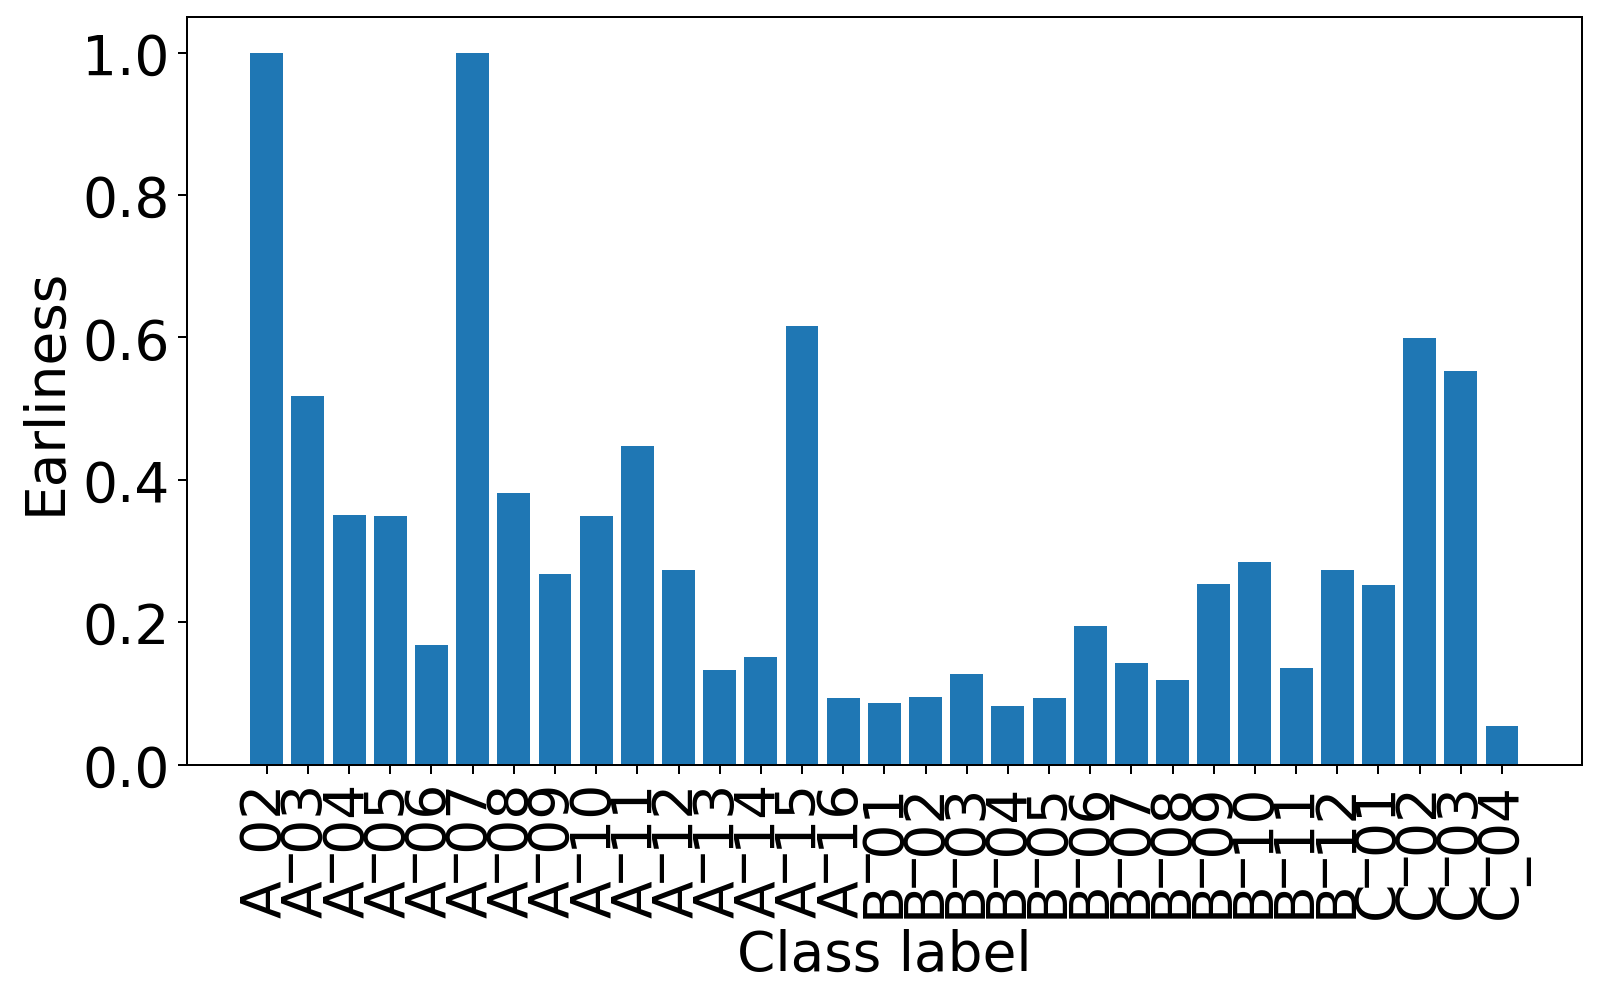

In [14]:
plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(10,5.5),dpi=180)
plt.xticks(rotation=90)


_ = plt.bar(actions, avPerClass)


plt.xlabel('Class label')
plt.ylabel('Earliness')
# plt.title('Histogram representing the earliness of each class')

# plt.savefig(pathModelGeneral+"earlinessPerClass", bbox_inches='tight')
# plt.savefig(pathModelGeneral+"earlinessPerClass.eps", bbox_inches='tight',format='eps')

## Behaviour with reject

Text(0, 0.5, 'Rate')

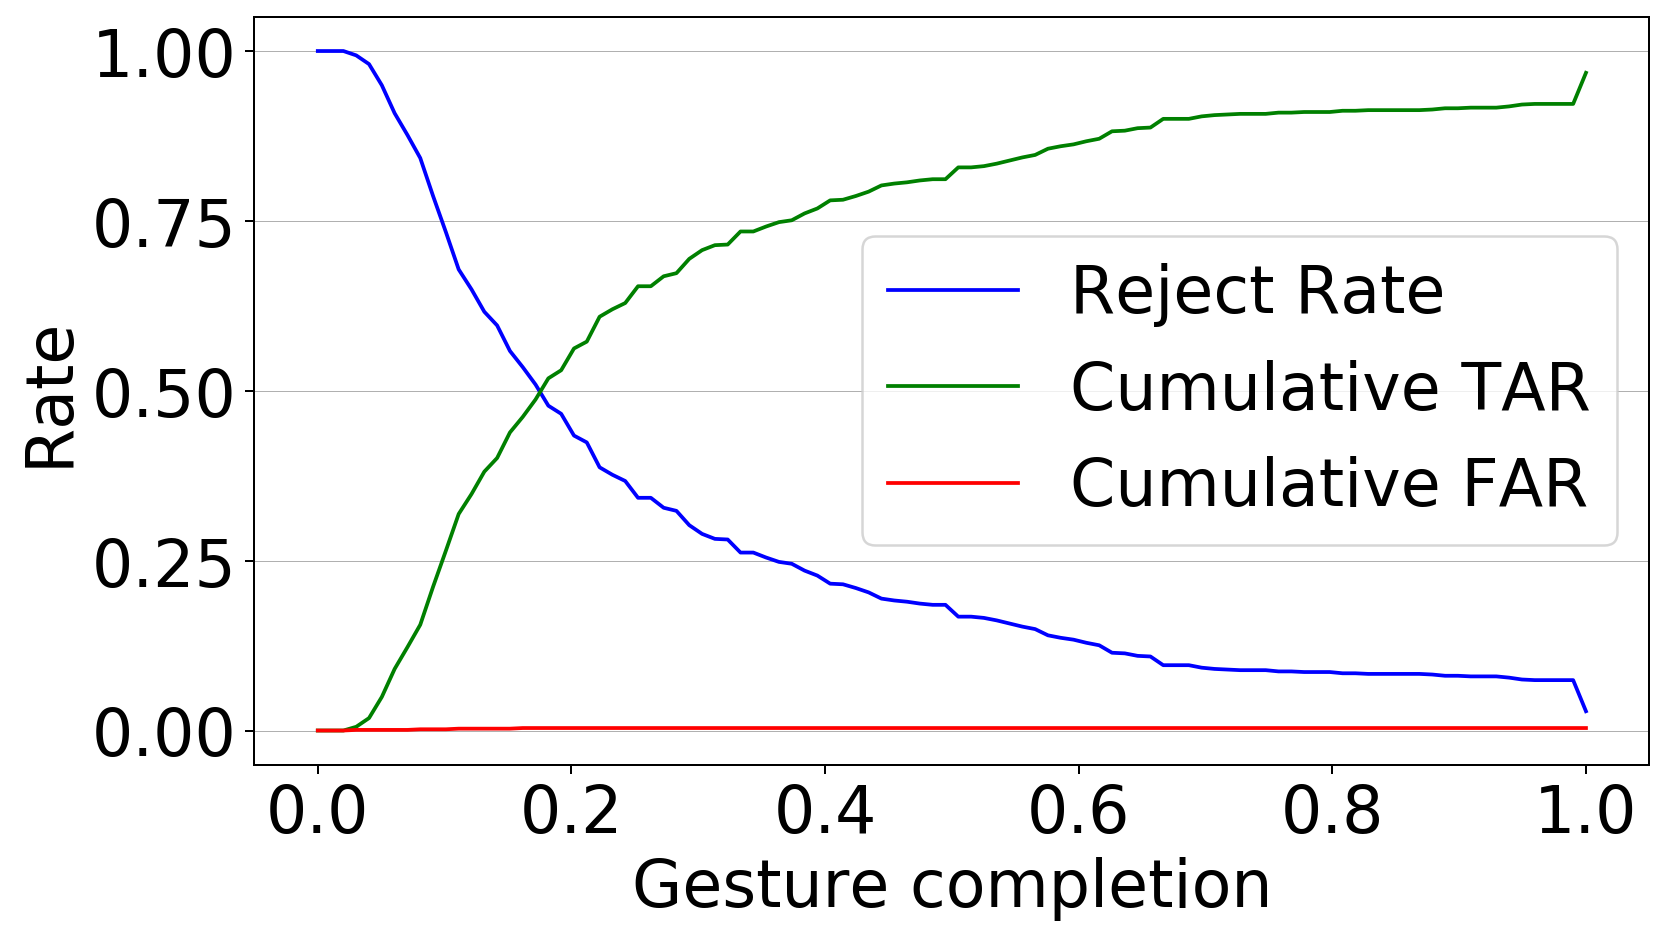

In [15]:
plt.rcParams.update({'font.size': 26})
plt.figure(figsize=(10,5.5),dpi=180)
xAbs = np.linspace(0,1,100)
flat_averageLengthCompletion = [item for sublist in averageLengthCompletion for item in sublist]

lengcomplt = np.array(flat_averageLengthCompletion)
# lengcomplt[]
rejectsAt = np.array(list(map(lambda x : 1-len(lengcomplt[lengcomplt<=x])/N_,xAbs)))
plt.plot(xAbs, rejectsAt,color="blue")


TrueAcceptAt = np.array(TrueAcceptAt)
FalseAcceptAt = np.array(FalseAcceptAt)
totalExemples = len(lengcomplt)

#cumulated TAR and FAR
TARAt = np.array(list(map(lambda x : len(TrueAcceptAt[TrueAcceptAt<=x])/N_,xAbs)))
plt.plot(xAbs, TARAt,color="green")



FARAt = np.array(list(map(lambda x : len(FalseAcceptAt[FalseAcceptAt<=x])/N_,xAbs)))
plt.plot(xAbs, FARAt,color="red")
plt.grid(axis="y",linestyle="-",linewidth=.4)

plt.legend(["Reject Rate","Cumulative TAR","Cumulative FAR"])
plt.xlabel("Gesture completion")
plt.ylabel("Rate")

# plt.plot(X, Yb)
# # plt.plot(X, Yb)
# plt.savefig(pathModelGeneral+"TAR_FAR_Reject.eps", bbox_inches='tight',format='eps')
# plt.savefig(pathModelGeneral+"TAR_FAR_Reject", bbox_inches='tight')
